In [3]:
def create_best_lstm_model(best_params):
    model = Sequential()
    n_layers = best_params['lstm_n_layers']
    units = best_params['lstm_units']
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        model.add(Dropout(rate=best_params['lstm_dropout']))
    model.add(Dense(1))
    learning_rate = best_params['lstm_learning_rate']
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


def create_lstm_model(trial):
    model = Sequential()
    n_layers = trial.suggest_int('lstm_n_layers', 2, 4)  # Optimize number of LSTM layers
    units = trial.suggest_categorical('lstm_units', [50, 100, 150, 200])
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        dropout_rate = trial.suggest_categorical('lstm_dropout', [0, 0.1, 0.2, 0.3, 0.4, 0.5])
        model.add(Dropout(rate=dropout_rate))  # Use specific dropout rate
    model.add(Dense(1))
    learning_rate = trial.suggest_categorical('lstm_learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])  # Optimize learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define optimization objective function
def objective_LSTM(trial):
    num_samples = X_train_lstm.shape[0] * 0.8
    batch_size_candidates = [16, 32, 64, 128, 256, 512, 1024, 2048]
    batch_size_candidates = [bs for bs in batch_size_candidates if bs <= num_samples]
    param = {
        'epochs': trial.suggest_categorical('lstm_epochs', [10, 20, 30, 40, 50, 75, 100, 150, 200]),
        'batch_size': trial.suggest_categorical('lstm_batch_size', batch_size_candidates)
    }
    param['batch_size'] = min(param['batch_size'], num_samples)  # Ensure batch_size does not exceed the number of samples in the training dataset
    model = KerasRegressor(build_fn=lambda: create_lstm_model(trial), epochs=param['epochs'], batch_size=param['batch_size'], verbose=0)
    
    # Use 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, val_index in kf.split(X_train_lstm):
        X_train, X_val = X_train_lstm[train_index], X_train_lstm[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        num_samples = X_train.shape[0]
        # 'patience' parameter defines how many epochs the model continues training without improvement before stopping
        # 'restore_best_weights' if True, the model's weights will be restored to the point with the lowest validation loss
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train_fold, validation_data=(X_val, y_val), callbacks=[early_stopping, KerasPruningCallback(trial, 'val_loss')])
        
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)


def plot_importance(df_importances, output_path, model_name, region, filename):
    """
    Plot bar chart and concentric pie chart of feature importance.

    Parameters:
        df_importances (DataFrame): Feature importance data, required to contain a 'feature' column.
        output_path (str): Base path for output files.
        model_name (str): Model name, used for folder structure and file naming.
        region (str): Region name, used for output file naming.
        filename (str): Full path of the output file (including name and extension).
    """
    # Categorize features
    # Feature-to-category mapping
    category_map = {
        'KNDVI': 'VI',          # Vegetation Index
        'EVI': 'VI',            # Vegetation Index
        'NDVI': 'VI',           # Vegetation Index
        'modis_Gpp': 'VI',      # Vegetation Index (Gross Primary Productivity)
        'Fpar': 'VI',           # Vegetation Index (Fraction of Photosynthetically Active Radiation)
        'modis_LAI': 'VI',      # Vegetation Index (Leaf Area Index)
        'PML_Gpp': 'VI',        # Vegetation Index (Gross Primary Productivity from PML model)
        'Mean_Yield': 'TI',     # Temporal Index (Long-term average yield)
        'Previous_Yield': 'TI', # Temporal Index (Previous year's yield)
        'year': 'TI',           # Temporal Index (Year as a temporal feature)
        'Pre': 'MC',            # Meteorological Conditions (Precipitation)
        'Tmin': 'MC',           # Meteorological Conditions (Minimum Temperature)
        'Solar': 'MC',          # Meteorological Conditions (Solar Radiation)
        'Tmean': 'MC',          # Meteorological Conditions (Mean Temperature)
        'Tmax': 'MC',           # Meteorological Conditions (Maximum Temperature)
        'CDD': 'EC',            # Extreme Climate (Cooling Degree Days)
        'HDD': 'EC',            # Extreme Climate (Heating Degree Days)
        'GDD': 'EC',            # Extreme Climate (Growing Degree Days)
        'VPD': 'EC',            # Extreme Climate (Vapor Pressure Deficit)
        'SPEI': 'EC',           # Extreme Climate (Standardized Precipitation-Evapotranspiration Index)
        'wind_speed': 'EC',     # Extreme Climate (Wind Speed)
        'SAND': 'CEC',          # Climatic and Edaphic Conditions (Soil sand content)
        'AWC': 'CEC',           # Climatic and Edaphic Conditions (Available Water Capacity)
        'SILT': 'CEC',          # Climatic and Edaphic Conditions (Soil silt content)
        'ORG_CARBON': 'CEC',    # Climatic and Edaphic Conditions (Soil organic carbon)
        'TOTAL_N': 'CEC',       # Climatic and Edaphic Conditions (Total soil nitrogen)
        'PH_WATER': 'CEC',      # Climatic and Edaphic Conditions (Soil pH in water)
        'CEC_SOIL': 'CEC',      # Climatic and Edaphic Conditions (Cation Exchange Capacity)
        'CLAY': 'CEC',          # Climatic and Edaphic Conditions (Soil clay content)
        'elevation': 'CEC',     # Climatic and Edaphic Conditions (Elevation)
        'lat': 'CEC',           # Climatic and Edaphic Conditions (Latitude)
        'lon': 'CEC'            # Climatic and Edaphic Conditions (Longitude)
    }
    # Set file save path
    folder_path = os.path.join(output_path, 'figure', 'results', model_name)
    os.makedirs(folder_path, exist_ok=True)

    # Calculate mean feature contribution
    df_importances_mean = df_importances.mean(axis=1).reset_index()
    df_importances_mean['Category'] = df_importances_mean['feature'].map(category_map)
    df_importances_mean = df_importances_mean[['feature', 0, 'Category']]
    df_importances_mean.columns = ['Feature', 'Contribution', 'Category']

    # Exclude baseline feature and sort by category and contribution
    contribution_df_sorted = df_importances_mean[df_importances_mean['Feature'] != 'BASELINE']
    contribution_df_sorted = contribution_df_sorted.sort_values(by=['Category', 'Contribution'], ascending=[True, False])

    # Define category colors and gradient function
    category_colors = {
        'VI': (0.9, 0.7, 0.2, 1),  # Yellow
        'TI': (0.6, 0.3, 0.9, 1),  # Purple
        'MC': (0.7, 0.3, 0.3, 1),  # Dark red
        'EC': (0.2, 0.9, 0.9, 1),  # Cyan
        'CEC': (0.3, 0.6, 0.9, 1)  # Light blue
    }
    default_color = (0.8, 0.8, 0.8, 1)  # Gray

    def get_color_gradient(base_color, num_shades):
        gradient = np.linspace(0.4, 1, num_shades)
        return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

    # Inner and outer circle data for pie chart
    inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
    outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

    # Create color gradient for outer circle
    outer_colors = []
    for category in inner_contribution.index:
        category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
        base_color = category_colors.get(category, default_color)
        gradient_colors = get_color_gradient(base_color, len(category_df))
        outer_colors.extend(gradient_colors)

    # Plot figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=1200)
    ax.set_facecolor('#f0f0f0')
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

    # Plot horizontal bar chart (sorted by contribution descending)
    contribution_df_sorted = contribution_df_sorted.sort_values(by='Contribution', ascending=False)
    bar_colors = [category_colors.get(cat, default_color) for cat in contribution_df_sorted['Category']]
    ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors)
    ax.set_xlabel('Contribution')
    ax.set_ylabel('Feature')
    ax.set_title('Feature Contributions by Category')
    ax.invert_yaxis()  # Invert y-axis to display top contributors at the top

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
    ax.legend(handles, category_colors.keys(), loc='lower right')

    # Embed concentric pie chart
    inset_ax = inset_axes(ax, width=2, height=2, loc='upper right', bbox_to_anchor=(0.8, 0.35, 0.2, 0.2), bbox_transform=ax.transAxes)
    # Inner pie chart (category-level contribution)
    inset_ax.pie(inner_contribution, labels=[''] * len(inner_contribution), autopct='%1.1f%%', radius=1,
                 colors=[category_colors.get(cat, default_color) for cat in inner_contribution.index], wedgeprops=dict(width=0.3, edgecolor='w'))
    # Outer pie chart (feature-level contribution)
    inset_ax.pie(outer_contribution, labels=[''] * len(outer_contribution), radius=0.7, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
    # Add white center circle
    inset_ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))

    # Save figure (TIFF format for high-quality academic use)
    plt.savefig(filename, format='tiff', bbox_inches='tight')
    plt.show()

def plt_scatter(data, filename):
    dataframes = data[['predicts', 'records']]
    r2 = r2_score(dataframes['records'], dataframes['predicts'])
    # Calculate NRMSE (Normalized Root Mean Square Error)
    mse = mean_squared_error(dataframes['records'], dataframes['predicts'])
    nrmse = np.sqrt(mse) / np.mean(dataframes['records'])
    rrmse = calculate_rrmse1(dataframes['records'], dataframes['predicts'])
    
    mape = mean_absolute_percentage_error(dataframes['records'], dataframes['predicts'])
    acc = calculate_acc(dataframes['records'], dataframes['predicts'])
    
    # Create scatter plot with hexbin density
    plt.figure(figsize=(10, 6))
    plt.hexbin(dataframes['records'], dataframes['predicts'], gridsize=50, cmap='viridis', mincnt=1)
    cb = plt.colorbar(label='Density')  # Color bar for density visualization
    
    # Add linear fit line
    fit_params = np.polyfit(dataframes['records'], dataframes['predicts'], 1)
    fit_line = np.polyval(fit_params, dataframes['records'])
    plt.plot(dataframes['records'], fit_line, color='red', label='Fit line')
    
    # Add 1:1 reference line
    max_val = max(max(dataframes['records']), max(dataframes['predicts']))
    plt.plot([0, max_val], [0, max_val], linestyle='--', color='green', label='1:1 line')
    
    # Set plot labels and layout
    plt.title('')
    plt.xlabel('Observed values')
    plt.ylabel('Predicted values')
    plt.grid(True)
    
    # Add evaluation metrics text
    plt.text(0.02, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')
    plt.text(0.02, 0.90, f'ACC = {acc:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')
    plt.text(0.02, 0.85, f'RRMSE = {rrmse:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')
    plt.text(0.02, 0.80, f'MAPE = {mape*100:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')
    
    # Save and display figure
    plt.savefig(filename)
    plt.show()

def extract_selected_variables(inputpath_base):
    inpath_dates = os.path.join(inputpath_base, 'dataset', "01_inputdata", 'selectFeatures.txt')
    # Construct file path
    gs_infornamtion = pd.read_csv(inpath_dates, sep='\t', header=None)
    gs_infornamtion.columns = ['slected_dynamic_features', 'slected_static', 'regionID']
    gs_infornamtion['slected_dynamic_features'] = gs_infornamtion['slected_dynamic_features'].apply(ast.literal_eval)
    gs_infornamtion['slected_static'] = gs_infornamtion['slected_static'].apply(ast.literal_eval)
    return gs_infornamtion

def calculate_rrmse1(y_true, y_pred):
    """
    Calculate RRMSE (Relative Root Mean Square Error) using the mean of actual values as reference.
    
    Parameters:
    y_true -- Array or list of true values
    y_pred -- Array or list of predicted values
    
    Returns:
    rrmse -- Relative Root Mean Square Error (percentage)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Calculate mean of true values
    mean_y_true = np.mean(y_true)
    
    # Calculate RRMSE
    rrmse = (rmse / mean_y_true) * 100
    
    return rrmse

def calculate_rrmse2(y_true, y_pred):
    """
    Calculate rRMSE (Relative Root Mean Square Error) using each individual actual value as reference.
    
    Parameters:
    y_true -- Array or list of true values
    y_pred -- Array or list of predicted values
    
    Returns:
    rrmse -- Relative Root Mean Square Error (percentage)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate rRMSE
    rrmse = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    
    return rrmse

# Define custom nRMSE evaluation function
def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse = rmse / (y_true.max() - y_true.min())
    return nrmse * 100

def calculate_acc(y_true, y_pred):
    # Calculate means of observed and predicted values
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Calculate anomalies (deviations from the mean)
    anomaly_true = y_true - mean_true
    anomaly_pred = y_pred - mean_pred
    
    # Calculate ACC (Anomaly Correlation Coefficient)
    numerator = np.sum(anomaly_true * anomaly_pred)
    denominator = np.sqrt(np.sum(anomaly_true**2) * np.sum(anomaly_pred**2))
    
    acc = numerator / denominator
    return acc

In [5]:
import os
import sys
import ast
sys.path.append(r'C:\ProgramData\anaconda3\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\myenv\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\rasterio_env\Lib\site-packages') 
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import optuna
from optuna_integration.keras import KerasPruningCallback
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.model_selection import train_test_split
from IPython.display import display
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
import json

countryID = '06_India';
country =countryID[3:]
crop = '02_wheat';yield_type= 'actual_yield';

inputpath_base = os.path.dirname(os.getcwd())
startyear = 2001;endyear = 2018
Forecastyear = endyear
region = 'I'
Forecastyears = {
    'I': Forecastyear}
years = range(startyear,endyear+1)
years_str = [str(year) for year in years]
modelname = 'LSTM'
yield_type = 'actual_yield';
SelFeature_infornamtion = extract_selected_variables(inputpath_base)
institution = 'ECMWF';

inpath_dates = os.path.join(inputpath_base, 'dataset',"01_inputdata",'gs_three_periods.txt')
gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


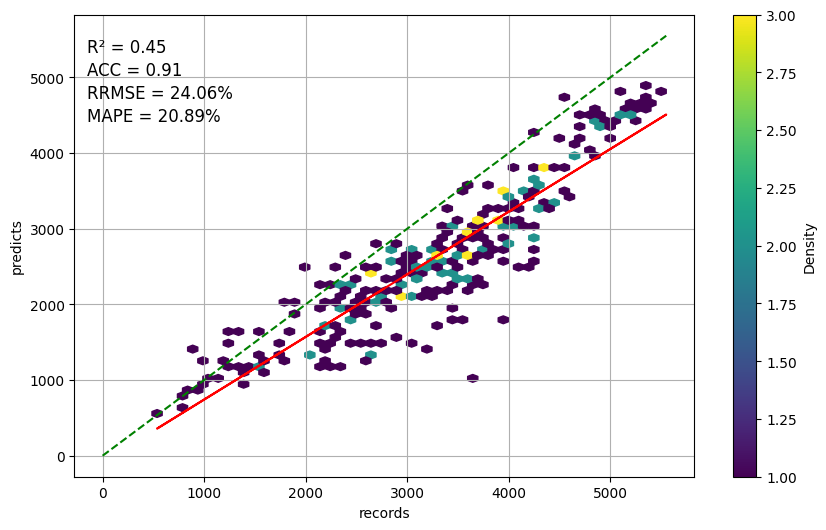

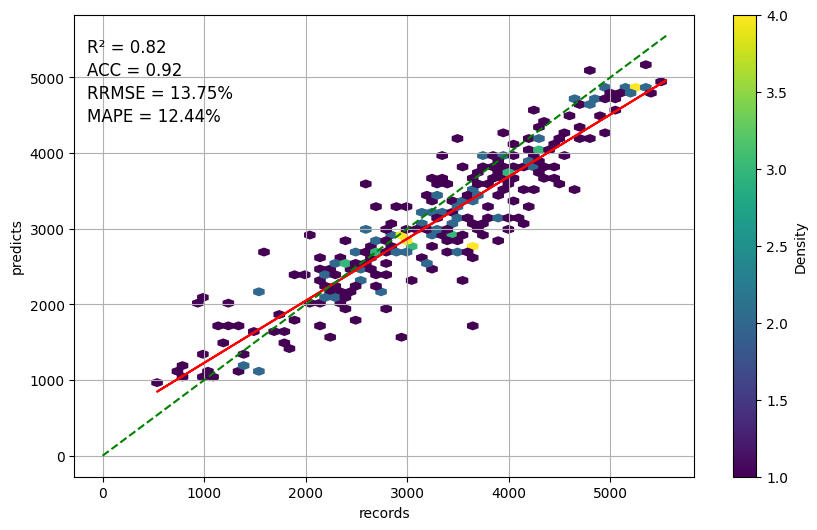

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
###################Load Selected Feature Variables#########################################
Forecastyear = Forecastyears[region]  # Get forecast year for the target region
# Load original dataset
data = pd.read_csv(os.path.join(inputpath_base, 'dataset', "01_inputdata", region + '_data_ori.csv'))
data = data.drop_duplicates(subset=['year', 'idJoin'], keep='first')  # Remove duplicate records (retain first occurrence)

# Extract selected dynamic features, static features, and region ID
TimeFeatures_sel, Static_sel, regionID = SelFeature_infornamtion[SelFeature_infornamtion['regionID'] == region].iloc[0]
feature_all = TimeFeatures_sel + Static_sel  # Combine dynamic and static features into a complete feature list
# Filter columns containing any of the selected features
filtered_columns = [col for col in data.columns if any(feature in col for feature in feature_all)]
filtered_columns = [col for col in filtered_columns if 'year.1' not in col]  # Exclude redundant year column ('year.1')


####Exclude yield-related features if present#########################
filtered_columns = [col for col in filtered_columns if 'Yield' not in col]  # Exclude yield-related features
Static_sel = [col for col in Static_sel if 'Yield' not in col]  # Update static features (remove yield-related items)
feature_all = [col for col in feature_all if 'Yield' not in col]  # Update complete feature list (remove yield-related items)
#############################################################

# Construct machine learning dataset (selected features + target yield)
MLdata_reduced = data[filtered_columns + [yield_type]]
MLdata_reduced['year'] = data['year']  # Add year column back to the dataset

############################Data Standardization###########################################################
data_all = MLdata_reduced  # Full dataset for modeling
X_all = data_all.drop([yield_type], axis=1)  # Feature matrix (exclude target variable)
y_all = data_all[yield_type]  # Target variable (yield)

# Standardize feature matrix and target variable (fit scaler on full dataset)
scaler_X = StandardScaler().fit(X_all)
scaler_y = StandardScaler().fit(y_all.values.reshape(-1, 1))

############################Convert to LSTM Input Format###########################################################
dataframes = pd.DataFrame()  # Placeholder for prediction results
df_importances = pd.DataFrame()  # Placeholder for feature importance results
# Create output directory for results
os.makedirs(os.path.join(inputpath_base, 'results', modelname, region), exist_ok=True)

# Prepare training data (all years except forecast year)
data_all = MLdata_reduced[(MLdata_reduced['year'] < Forecastyear)]
X_all = data_all.drop([yield_type], axis=1)
y_all = data_all[yield_type]
# Apply standardization to training data
X = scaler_X.transform(X_all)
y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()
# Convert standardized features back to DataFrame for column-based operations
X = pd.DataFrame(data=X, columns=X_all.columns.tolist())

# Generate list of growth stage weeks (handle cross-year growth periods)
if start_point > harvest_point:
    # Cross-year growth period (e.g., winter crops): combine weeks from start_point to 46 and 1 to harvest_point
    weeks_select_list = list(range(start_point, 47)) + list(range(1, harvest_point + 1))
else:
    # Same-year growth period: direct range from start_point to harvest_point
    weeks_select_list = list(range(start_point, harvest_point + 1))

# Reshape training data into 3D format (samples, time steps, features) required for LSTM
data_list = []
for i in weeks_select_list:
    # Extract features for the i-th week (dynamic features + static features)
    data_i = X[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
    data_list.append(data_i.values)  # Store weekly feature matrices in a list

# Stack weekly feature matrices into a 3D array and transpose to (samples, time steps, features)
data_list = np.array(data_list)
X_train_lstm = np.transpose(data_list, (1, 0, 2))
y_train = y  # Standardized training target

# Prepare test data (only forecast year)
data_test = MLdata_reduced[(MLdata_reduced['year'] == Forecastyear)]
X_test = data_test.drop([yield_type], axis=1)
y_test = data_test[yield_type]
# Apply standardization to test data (use scaler fitted on training data)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Reshape test data into 3D format (samples, time steps, features)
data_list = []
X_test = pd.DataFrame(data=X_test, columns=X_all.columns.tolist())
for i in weeks_select_list:
    data_i = X_test[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
    data_list.append(data_i.values)
data_list = np.array(data_list)
X_test_lstm = np.transpose(data_list, (1, 0, 2))

# Randomly split training data into 8:2 for training and validation
x_train_lstm, x_val_lstm, y_train, y_val = train_test_split(X_train_lstm, y_train, test_size=0.2, random_state=42)

## Train and save the model (commented out; use pre-trained model instead)
'''
# Load saved best hyperparameters from JSON file to build the model
input_params_path = os.path.join(save_dir, f"{study_name}_best_params.json")
with open(input_params_path, "r") as f:
    best_params = json.load(f)
    
model = create_best_lstm_model(best_params)  # Initialize model with best hyperparameters
# Early stopping: stop training if validation loss doesn't improve for 15 epochs, restore best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train the model
model.fit(x_train_lstm, y_train, validation_data=(x_val_lstm, y_val), 
          epochs=best_params['lstm_epochs'], batch_size=best_params['lstm_batch_size'], 
          callbacks=[early_stopping])

# Save the trained model
outpathmodel = os.path.join(inputpath_base, 'Trained model')
os.makedirs(outpathmodel, exist_ok=True)
model_path = os.path.join(outpathmodel, region + 'my_lstm_model.keras')
model.save(model_path)
'''
# Load pre-trained model
outpathmodel = os.path.join(inputpath_base, 'Trained model')
model_path = os.path.join(outpathmodel, region + 'my_lstm_model.keras')
model = load_model(model_path)

# Evaluate accuracy on Test (Forecast year) data
y_pred = model.predict(X_test_lstm)
# Inverse transform standardized predictions and true values to original scale
y_pred_inverse = scaler_y.inverse_transform(y_pred)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
# Create DataFrame to store prediction results
data_pre = pd.DataFrame({'predicts': y_pred_inverse.ravel(), 'records': y_test_inverse.ravel()})
data_pre['year'] = Forecastyear  # Add forecast year column

# Save results
os.makedirs(os.path.join(inputpath_base, 'results', modelname, region), exist_ok=True)
data_pre.to_csv(os.path.join(inputpath_base, 'results', modelname, region, str(Forecastyear) + '.csv'), index=False)
df_importances.to_csv(os.path.join(inputpath_base, 'results', modelname, region, f'lstm_importance_all in {region}.csv'), index=False)

#############Compare if model accuracy is better than ZeroR algorithm (baseline)#######################################
Test_year = Forecastyear
# Reshape yield data into pivot table (index: region ID, columns: years, values: actual yield)
data1 = data[['year', 'actual_yield', 'idJoin']].pivot(index='idJoin', columns='year', values='actual_yield')
# Split into training (all years before forecast year) and test (forecast year) for ZeroR
train_df = data1.iloc[:, 0:Forecastyear - startyear]
test_df = data1.loc[:, Forecastyear]

# ZeroR algorithm: predict yield as the mean of training years for each region
train_means = train_df.mean(axis=1)
# Combine ZeroR predictions and true values
combined = pd.concat([train_means.reset_index(drop=True), test_df.reset_index(drop=True)], axis=1)
combined_cleaned = combined.dropna()  # Remove rows with NaN values
combined_cleaned.columns = ['predicts', 'records']  # Rename columns for consistency

# Create directory for figures
folder_path = os.path.join(inputpath_base, 'figure', modelname)
os.makedirs(folder_path, exist_ok=True)

# Plot scatter plot for ZeroR model (baseline)
filename = os.path.join(folder_path, f'null model scatter in {region} in {Forecastyear}.tiff')
plt_scatter(combined_cleaned, filename)  # Generate scatter plot for baseline model

# Plot scatter plot for LSTM model predictions
filename = os.path.join(folder_path, f'prediction scatter in {region} in {Forecastyear}.tiff')
plt_scatter(data_pre, filename)  # Generate scatter plot for LSTM predictions

# Calculate feature importance using Permutation Feature Importance (PFI)
results = []
# Get out-of-fold (validation set) predictions with original features
oof_preds = model.predict(x_val_lstm, verbose=0).squeeze()
# Baseline MAE (mean absolute error) with original features
baseline_mae = np.mean(np.abs(oof_preds - y_val))
results.append({'feature': 'BASELINE', 'mae': baseline_mae})
results = []  # Reset results list (only keep permutation results)

# Iterate over each feature and shuffle to calculate importance
for k in tqdm(range(len(feature_all))):
    # Save original feature values
    save_col = x_val_lstm[:, :, k].copy()
    # Shuffle the k-th feature across all samples and time steps
    np.random.shuffle(x_val_lstm[:, :, k])
    # Predict with shuffled feature and calculate MAE
    oof_preds = model.predict(x_val_lstm, verbose=0).squeeze()
    mae = np.mean(np.abs(oof_preds - y_val))
    # Store feature name and corresponding MAE
    results.append({'feature': feature_all[k], 'mae': mae})
    # Restore original feature values
    x_val_lstm[:, :, k] = save_col

# Save permutation feature importance results
df = pd.DataFrame(results)
df = df.sort_values('mae')  # Sort by MAE (lower MAE = less important feature)
df.to_csv(os.path.join(inputpath_base, 'results', modelname, region, f'lstm_importance{Forecastyear}.csv'), index=False)
# Rename column to forecast year and set feature as index for combining multiple years
df.rename(columns={'mae': Forecastyear}, inplace=True)
df.set_index('feature', inplace=True)
# Combine with existing importance results (for multiple forecast years)
df_importances = pd.concat([df, df_importances], axis=1)

# Plot feature importance
filename = os.path.join(folder_path, f'importance in {region} in {Forecastyear}.tiff')
plot_importance(df_importances, inputpath_base, modelname, region, filename)

In [15]:
'''
# 2. Extract specific hyperparameter values

model_path = os.path.join(outpathmodel, region + 'my_lstm_model.keras')
model = load_model(model_path)
print("\n" + "="*50)
print("Specific hyperparameter settings:")
print("="*50)

# Get LSTM layers and Dropout layers
lstm_layers = [l for l in model.layers if 'lstm' in l.name]
dropout_layers = [l for l in model.layers if 'dropout' in l.name]

# Print key parameters
print(f"• Number of LSTM layers: {len(lstm_layers)}")
print(f"• Number of neurons per layer: {lstm_layers[0].units} (same for all layers)")

if dropout_layers:
    print(f"• Dropout rate: {dropout_layers[0].rate:.1f} (same for all layers)")
else:
    print("• Dropout rate: Not used")

# 3. Get optimizer parameters
optimizer = model.optimizer
if optimizer:
    print(f"• Optimizer type: {optimizer.__class__.__name__}")
    print(f"• Learning rate: {optimizer.learning_rate.numpy():.6f}")
else:
    print("• Optimizer information: Not saved")

# 4. Get input/output dimensions
input_shape = model.input_shape[1:]  # Exclude batch dimension (None)
output_shape = model.output_shape[1:]  # Exclude batch dimension (None)
print(f"\n• Input dimension (time steps, features): {input_shape}")
print(f"• Output dimension: {output_shape}")
'''


超参数具体设置:
• LSTM 层数: 3
• 每层神经元数: 100 (所有层相同)
• Dropout 丢弃率: 0.2 (所有层相同)
• 优化器类型: Adam
• 学习率: 0.001000

• 输入维度: (19, 17)
• 输出维度: (1,)


In [ ]:
# Hyperparameter Optimization
'''
storage_name = f"sqlite:///{country}_{country}_{modelname}_region{region}_1007.db"
study_name = f"{country}_{modelname}_region{region}_1007"
# Create Optuna study: minimize loss, use TPE sampler, load existing study if it exists
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(), study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective_LSTM, n_trials=100, n_jobs=4)  # Use 16-core CPU for parallel computing (adjust n_jobs based on actual CPU cores)

# Print best hyperparameters
print('Best parameters: ', study.best_params)
print('Best MSE: ', study.best_value)

# Load existing study
import matplotlib.pyplot as plt
# Visualize parameter importance
optuna.visualization.plot_param_importances(study)
plt.show()

# Visualize convergence
df = study.trials_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(df['number'], df['value'])
plt.xlabel('Trial')
plt.ylabel('MSE')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()
'''

[I 2024-12-06 16:32:56,442] A new study created in RDB with name: China_LSTM_regionII_1007
